# Introduction

Computer vision has gained traction in the recent years because of its state of the art performance in tasks such as image classification, object detection, speech recognition and more. It has found application in wide fields and in this tutorial we are going to handle basic image classification and in a later post deploy it.


Image classification refers to a process in computer vision that classifies images according to its visual content e.g, an image classification algorithmn to indentify if an image contains a car or a truck.

In this you will learn how to train models using TensorFlow 2.X and TensorFlow Hub, we will build a models using tf.keras.Sequatial and load data with tf.keras.processing.image. 

[TensorFlow Hub](https://www.tensorflow.org/hub) is a module for reuseable machine learning models, it will help us perform transfer learning by training and fine tuning an already trained model. Tranfer learning is a technique in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem [wikipedia](https://en.wikipedia.org/wiki/Transfer_learning). Will take advantage of mobilenet model which is a small model that runs well on mobile devices since we will deploy it later in [this]() post.

The data used is furniture dataset from [kaggle](https://www.kaggle.com/akkithetechie/furniture-detector).

# Tutorial Overview
This tutorial is divided into seven parts namely;
- Data Understanding, Processing and Visualization
- Model Preparation
- Model Training 
- Model Performance Analysis
- Model Conversion and Testing

Above represents the common procedure followed in a machine learning task. Without futher ado let's jump right in and start coding, enjoy.

# Handle Imports
Let's start by importing the necessary packages we will be using. tensorflow is our main package for developing the model, tensorflow_hub for reusable models , matplotlib and for visualization and numpy to perform some mathematical computations.

In [1]:
# Import Important Libraries

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Mathematical operation
import numpy as np

In [2]:
# Initialize parameters and dataset directories
# data directory
DATADIR  = "../../DATASETS/FUNITURE/"
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32

IMAGE_SIZE = (WIDTH, HEIGHT, 3,)

# Data Understanding, Processing and Visualization
To understand the kind of data we are dealing we need to visualize them but first we will build the dataset using tf.keras.preprocessing.image and write helper function to visualize the image batch


In [3]:
# define generator
train_gen =ImageDataGenerator(rescale=1./255)
val_gen =ImageDataGenerator(rescale=1./255)

Get the data from directory, and reshape it to a shape of 224 by 224 since the model will be using requiires that size

In [4]:
train_data = train_gen.flow_from_directory(
    DATADIR+"train",
    target_size=(WIDTH, HEIGHT)
)
val_data = val_gen.flow_from_directory(
    DATADIR+"val",
    target_size=(WIDTH, HEIGHT)
)

Found 4024 images belonging to 5 classes.
Found 423 images belonging to 5 classes.


In [5]:
# a function to show the image batch
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0])
        plt.axis('off')

Use show_batch function to visualize the dataset and acertain that its well formatted

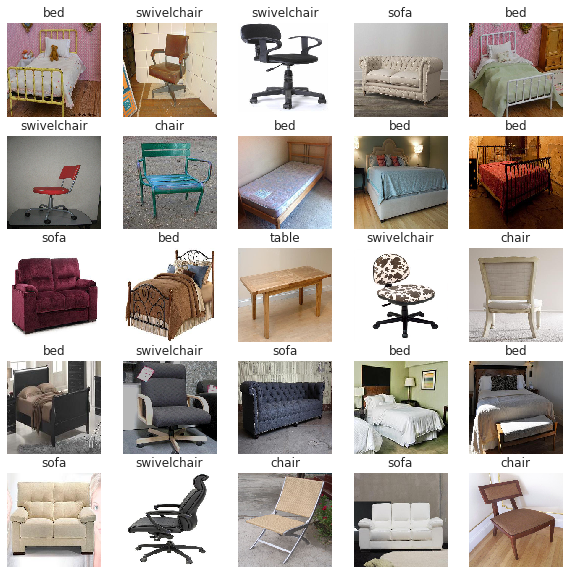

In [6]:
class_names = np.array(list(train_data.class_indices.keys())) # get class names
image_batch, label_batch = next(iter(train_data))
show_batch(image_batch, label_batch, class_names)

lets save the class names to file since will need it later during deployment

In [7]:
with open("labels/labels.txt", "w") as l:
    for i in class_names:
        l.write(i)
        l.write("\n")
    l.close()

# Model Preparation
Now that the data is well prepared and ready for training, we will head over and start building our model. Make use of tf.keras.Sequential to build the model has in allows easy stacking of layers together. 

The model will consist of the following layers;
* InputLayer - layer that will pass our image shape

* hub.KerasLayer - get the pretrained model in this case mobilenet

* Dropout - reduces overfitting by preventing a layer from seeing twice the exact same pattern

* Dense layer - last layer with softmax activation function to return probability of classes


later will compile the model with 
- *SparseCategoricalCrossentropy* loss - measures how accurate the model is during training

- *Adam* optimizer- how the model is updated and 
- *CategoricalAccuracy* -monitors the training and testing steps

In [8]:
module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4" # mobilenet module

image_size = (WIDTH, HEIGHT, 3,)
num_classes = train_data.num_classes # get number of classes
print("Image Size", image_size)
print("Number of Classes", num_classes)

def build_model():
    model = Sequential([
        layers.InputLayer(input_shape=image_size),
        hub.KerasLayer(module_handle, trainable=False),
        layers.Dropout(rate=0.2),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.build((None,) + IMAGE_SIZE) # build the model
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model

Image Size (224, 224, 3)
Number of Classes 5


# Model Training 
It's time to start training by calling model.fit but first things first, we need calcuate  training steps and validation steps. Will also collect the traininig stats to perform analysis and use early stopping callback to prevent over fitting by stopping training when the validation loss starts increasing

In [9]:
steps_per_epoch = train_data.n // BATCH_SIZE
validation_steps = val_data.n // BATCH_SIZE
call_backs = [EarlyStopping(patience=3, monitor="val_loss")]

model = build_model()
history = model.fit(
    train_data,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps = validation_steps,
    callbacks=call_backs
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 13 steps
Epoch 1/2
125/125 [==============================] - 61s 489ms/step - loss: 0.2737 - categorical_accuracy: 0.9173 - val_loss: 0.2995 - val_categorical_accuracy: 0.9014
Epoch 2/2
125/125 [==============================] - 13s 108m

# Model Performance Analysis
Now that training is done it's time to visualize how the model learned. From the graphs below, we can see that we achived relatively small losses and hight accuaracies, validation accuracy of 95% is great. We can further decrease the loss and increase the accuracy with data augmentations.

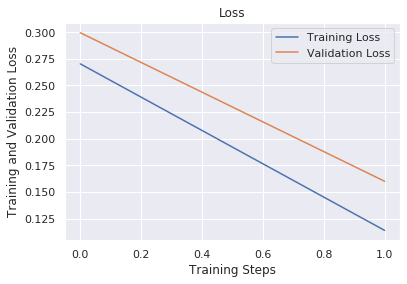

In [15]:
hist = history.history
plt.plot(hist["loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Training and Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

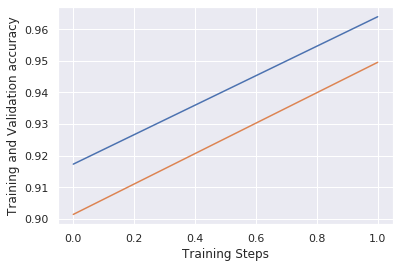

In [16]:
plt.plot(hist["categorical_accuracy"], label="Training Accuracy")
plt.plot(hist["val_categorical_accuracy"], label="Validation Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Training and Validation accuracy")
plt.show()

# Model Conversion
We have come a long way through from data preparation to training and are confident of the model we have build we will thus convert it to TensorFlow Lite to deploy on mobile device. Its good also to debug or test the converted model to acertain that it maitained.

Make use of tf.lite.TFLiteConverter.from_keras_model to define the converter, and futher optimize it.

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # get the model
# converter.optimizations = [tf.lite.Optimize.DEFAULT] # optimize
tflite_model = converter.convert() # convert
open("models/tflite_model.tflite", "wb").write(tflite_model) # write to disk

8895908

The model is now converted and we are ready to test it by using TensorFlow Lite interpreter which is a library that takes a model file, executes the operations it defines on input data, and provides access to the output. Input data should be reshaped to 1,224,224,3.

In [18]:
image_batch, label_batch = next(iter(val_data))
def test_tflite_model(images):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    # reshape input data
    interpreter.set_tensor(interpreter.get_input_details()[0]["index"], images)
    interpreter.invoke()
    probs = interpreter.get_tensor(interpreter.get_output_details()[0]["index"])
    return probs

Check for the full batch of 32, how many times does our converted tflite model predictions correspond to tf keras predictions and true labels

In [19]:
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in zip(image_batch, label_batch):
    tflite_predictions = test_tflite_model(image[None, ...])[0]
    tf_keras_model_predictions = model(image[None, ...]).numpy()[0]
    lite_label = np.argmax(tflite_predictions)
    tf_keras_label = np.argmax(tf_keras_model_predictions)
    true_label = np.argmax(label)
    if lite_label == tf_keras_label:
        count_lite_tf_agree += 1
    if lite_label == true_label:
        count_lite_correct += 1
    if count == 32:
        break
    count +=1

print("The number of times tf lite predictions corespond to tf keras model predictions : ", count_lite_tf_agree)
print("The number of times tf lite predictions corespond to correct predictions : ", count_lite_correct)

The number of times tf lite predictions corespond to tf keras model predictions :  32
The number of times tf lite predictions corespond to correct predictions :  31


# Conclusion
Cheers, we have reached the end our tutorial, hoping it has been fun. There are many things we haven't done like futher fine tuning the model and doing data augmentations. Thank you for going through the post now proceed to [deployment post]() to learn how the converted model is deployed.

# References
- [TensorFlow Hub Examples](https://github.com/tensorflow/hub/tree/master/examples)
- [TensorFlow Lite](https://www.tensorflow.org/lite)
- [Transfer Learning Definition](https://en.wikipedia.org/wiki/Transfer_learning)